Generate 200 terms and run it on LO, RI, Rand as starting point.
Then run a new reward mod env with different configurations, look at results.
Reward distributions (test_1): 1:10, 1:11
Reward distributions (test_2): 1:1, 1:4, 1:16, 1:32, 1:64, 1:128

In [ ]:
import random
import numpy as np
import pandas as pd
import sys
import matplotlib.pyplot as plt
from fitter import Fitter, get_common_distributions
from deap import tools, base, creator
import seaborn as sns

sys.path.append("../../")
from calculus.term import *
from calculus.strategy import *
from calculus.generation import *
from calculus.generation_threading import *

from calculus_utils.drawing import *
from calculus_utils.algorithms import *
from calculus_utils.outliers_cleaning import clear_arr

from vd_env.lambda_env import LambdaEnv
from vd_env.run_greedy_policy import run_greedy_policy
from vd_env.run_e_greedy_policy import run_e_greedy_policy

In [2]:
RANDOM_AVERAGE_COUNT = 20

terms, stepsLO = gen_filtered_lambda_terms_v2(count_terms=200)
stepsRI = [term.normalize(RightmostInnermostStrategy())[1] for term in tqdm(terms)]
stepsRand = [sum(term.normalize(RandomStrategy())[1] for i in range(RANDOM_AVERAGE_COUNT)) / RANDOM_AVERAGE_COUNT
             for term in tqdm(terms)]

100%|██████████| 200/200 [01:01<00:00,  3.26it/s]


In [3]:
print(f"Generated LO normalizable terms: {len(terms)}\n")
print(f"LO steps: {stepsLO}\n")
print(f"RI steps: {stepsRI}\n")
print(f"Rand steps: {stepsRand}\n")
print(f"LO max: {max(stepsLO)}")
print(f"RI max: {max(stepsRI)}")
print(f"Rand max: {max(stepsRand)}")

Generated LO normalizable terms: 200

LO steps: [4, 8, 13, 1, 5, 3, 9, 6, 1, 36, 3, 281, 11, 6, 3, 2, 3, 4, 18, 2, 8, 8, 12, 1, 11, 20, 6, 7, 1, 1, 1, 17, 3, 14, 3, 24, 7, 5, 5, 6, 7, 5, 4, 1, 4, 7, 5, 1, 34, 1, 10, 7, 7, 5, 9, 11, 5, 11, 1, 1, 5, 10, 6, 4, 9, 11, 12, 1, 1, 1, 34, 5, 4, 1, 6, 2, 11, 11, 2, 5, 6, 4, 7, 11, 3, 11, 2, 9, 6, 10, 13, 7, 8, 3, 7, 4, 10, 2, 6, 2, 12, 23, 3, 14, 14, 2, 2, 3, 10, 7, 6, 16, 14, 4, 1, 1, 7, 5, 19, 6, 4, 2, 5, 5, 2, 2, 3, 4, 19, 9, 19, 17, 4, 5, 4, 5, 8, 9, 5, 6, 3, 25, 8, 7, 21, 5, 3, 12, 2, 12, 18, 18, 6, 5, 8, 2, 89, 11, 14, 6, 9, 5, 13, 5, 7, 15, 9, 13, 8, 4, 1, 24, 10, 7, 3, 2, 3, 7, 11, 2, 16, 1, 14, 2, 5, 3, 8, 5, 4, 2, 8, 6, 2, 3, 13, 2, 13, 5, 1, 8]

RI steps: [8, 15, 15, 8, 5, 3, 11, 7, 7, 19, 3, 49, 12, 8, 7, 2, 3, 12, 19, 3, inf, 10, 12, 6, 12, 20, 6, 7, 13, 9, 7, 17, 12, 16, 5, 20, 7, 5, 5, 10, 12, 12, 5, 4, 8, 8, 6, 6, 18, 6, 11, 9, 8, 10, 5, 9, 6, 12, 1, 6, 8, 11, 6, 7, 12, 13, 12, 10, 9, 1, 15, 5, 5, 5, 6, 4, 13, 7, 4, 9, 8, 5, 11,

In [4]:
max_count_steps_rlenv = 100
strategies_env = [LeftmostOutermostStrategy(), RightmostInnermostStrategy()]

explore_actions = 100
epsilon = 0.1

In [5]:
def experiment(reward_values=(-1, 0)):
    env = LambdaEnv(strategies=strategies_env,
                    lambda_terms=terms,
                    max_step_term=max_count_steps_rlenv,
                    count_terms=len(terms),
                    reward_values=(-1, 0))

    _, steps_env = \
        run_e_greedy_policy(environment=env,
                            exploration=explore_actions,
                            max_term_reward=max_count_steps_rlenv,
                            epsilon=epsilon,
                            deterministic=False,
                            is_action_based=True,
                            return_steps=True)
    print(f"Steps eg orig: {steps_env}")
    wh_orig = np.array(env.get_weights_history())

    comp_data = {
        "E-greedy n-d a-b": (clear_arr(steps_env), "-"),
        "LO": (clear_arr(stepsLO), "-"),
        "RI": (clear_arr(stepsRI), "-"),
        "Rand": (clear_arr(stepsRand), "-"),
    }
    draw_cumulative_avg_comparison(comp_data, title=f"Clear avgcum, reward {reward_values}")

    comp_data = {
        "LO-w": (wh_orig[:, 0], "-"),
        "RI-w": (wh_orig[:, 1], "-")
    }
    draw_mult_lines(comp_data, title=f"Strategy weights for reward {reward_values}",
                    x_label="step_no", y_label="prob")

Steps eg orig: [5, 10, 15, 2, 5, 3, 14, 7, 2, 50, 3, 99, 12, 9, 4, 2, 3, 12, 19, 3, 14, 17, 12, 4, 12, 20, 6, 7, 2, 1, 1, 20, 3, 17, 5, 31, 7, 5, 5, 10, 11, 10, 5, 1, 8, 10, 5, 2, 42, 1, 14, 9, 8, 8, 5, 9, 6, 12, 1, 1, 7, 18, 8, 6, 12, 13, 12, 2, 2, 1, 18, 5, 5, 1, 6, 3, 13, 21, 2, 5, 6, 5, 11, 25, 4, 16, 8, 9, 7, 14, 15, 10, 8, 5, 7, 4, 13, 3, 7, 5, 12, 17, 3, 8, 18, 4, 9, 3, 10, 12, 7, 23, 16, 4, 1, 1, 9, 6, 16, 11, 4, 2, 11, 5, 4, 3, 9, 7, 26, 13, 31, 16, 10, 5, 4, 5, 9, 4, 7, 8, 3, 38, 11, 8, 31, 6, 4, 12, 3, 11, 17, 33, 9, 8, 8, 2, 84, 11, 10, 6, 9, 6, 15, 5, 14, 15, 11, 15, 9, 5, 4, 29, 15, 7, 6, 4, 5, 7, 11, 2, 16, 4, 14, 2, 5, 6, 10, 5, 4, 5, 8, 8, 2, 8, 14, 2, 14, 9, 1, 9]


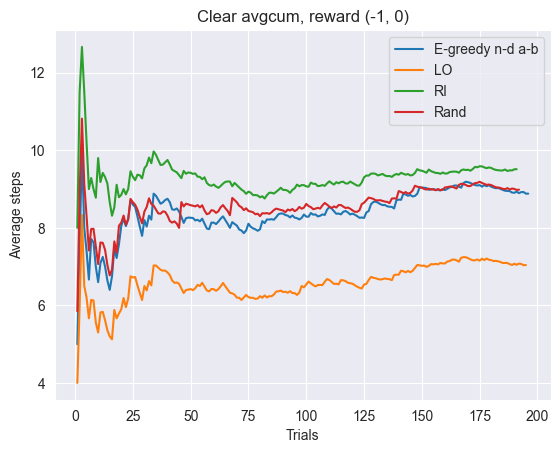

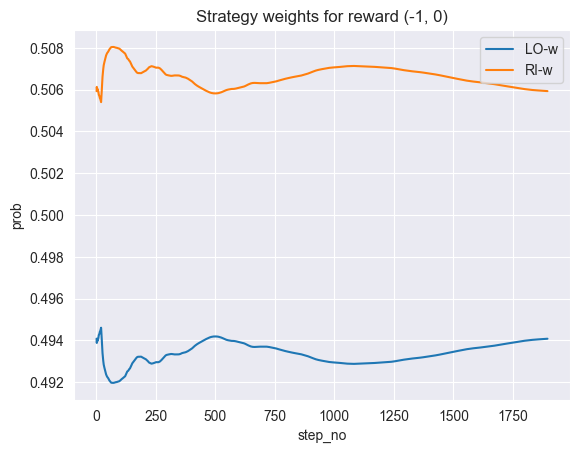

In [6]:
experiment(reward_values=(-1, 0))

# TEST 1

Steps eg orig: [5, 10, 15, 2, 5, 3, 14, 7, 2, 43, 3, 99, 12, 10, 3, 2, 3, 6, 20, 3, 11, 10, 12, 1, 12, 20, 6, 7, 3, 2, 1, 17, 5, 16, 3, 33, 7, 5, 5, 9, 12, 12, 4, 2, 8, 11, 6, 6, 45, 2, 12, 9, 8, 5, 9, 9, 6, 12, 1, 1, 6, 15, 9, 4, 12, 14, 12, 3, 1, 1, 34, 5, 4, 1, 6, 4, 13, 15, 2, 6, 6, 5, 12, 20, 4, 15, 2, 9, 7, 15, 15, 10, 4, 9, 7, 6, 12, 4, 8, 3, 12, 12, 3, 8, 20, 4, 4, 3, 10, 8, 7, 20, 17, 4, 1, 2, 12, 5, 19, 10, 4, 3, 14, 5, 3, 5, 5, 5, 33, 14, 23, 19, 10, 5, 4, 6, 10, 4, 6, 9, 3, 38, 8, 8, 24, 6, 3, 14, 2, 12, 18, 23, 9, 8, 8, 4, 84, 3, 12, 6, 9, 5, 15, 5, 8, 15, 11, 22, 8, 5, 2, 28, 13, 8, 5, 5, 3, 7, 15, 2, 16, 2, 14, 6, 5, 4, 10, 7, 4, 4, 8, 14, 2, 3, 15, 2, 13, 9, 2, 10]


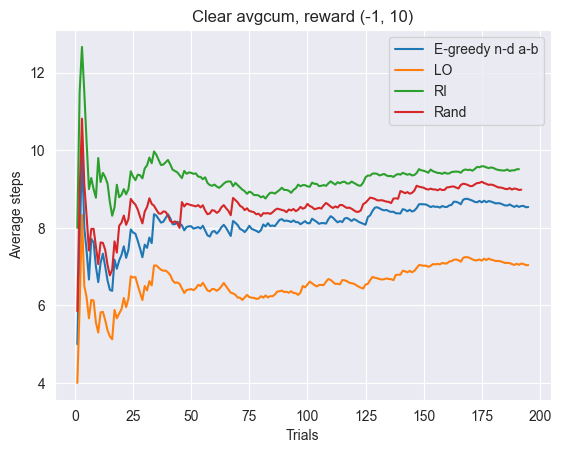

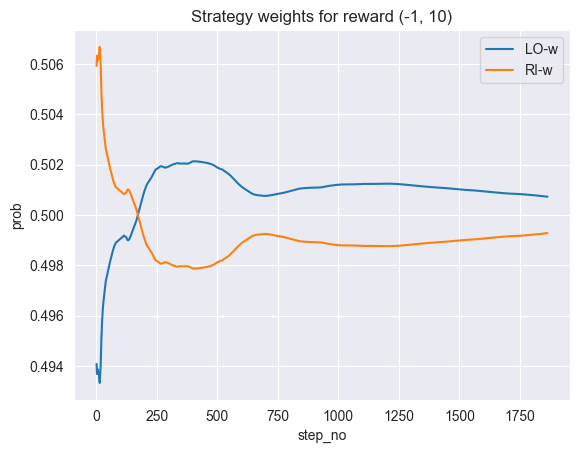

In [7]:
experiment(reward_values=(-1, 10))

Steps eg orig: [5, 10, 15, 2, 5, 3, 14, 7, 2, 50, 3, 99, 14, 8, 5, 2, 3, 4, 20, 3, 16, 15, 12, 1, 12, 20, 7, 7, 1, 1, 1, 23, 4, 16, 5, 23, 7, 5, 5, 10, 9, 6, 4, 1, 6, 7, 5, 2, 46, 5, 13, 9, 7, 6, 5, 9, 6, 12, 1, 1, 7, 12, 9, 6, 12, 12, 12, 2, 1, 1, 34, 5, 5, 5, 6, 4, 13, 10, 2, 9, 7, 5, 11, 22, 4, 15, 5, 9, 6, 16, 14, 10, 4, 3, 7, 5, 16, 4, 12, 4, 12, 18, 3, 8, 20, 4, 2, 3, 10, 7, 7, 18, 16, 4, 2, 5, 11, 6, 18, 12, 4, 5, 8, 5, 3, 5, 6, 5, 29, 13, 24, 16, 6, 8, 4, 7, 7, 9, 7, 9, 3, 39, 13, 7, 36, 6, 6, 13, 3, 12, 17, 25, 5, 8, 8, 3, 84, 3, 6, 6, 9, 6, 15, 5, 9, 16, 11, 12, 9, 5, 2, 21, 17, 9, 7, 7, 3, 7, 17, 3, 12, 1, 14, 6, 5, 3, 11, 7, 4, 6, 8, 14, 2, 4, 17, 2, 13, 7, 2, 10]


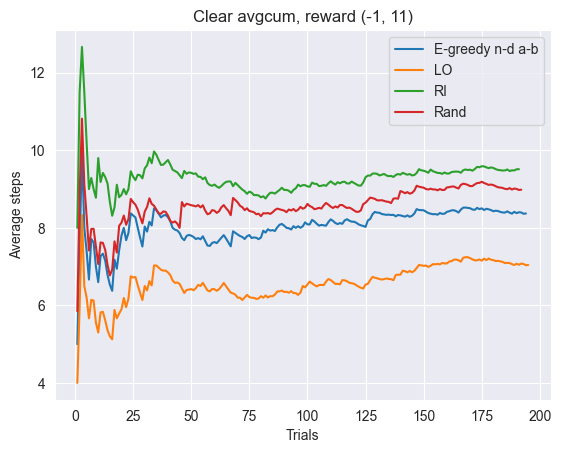

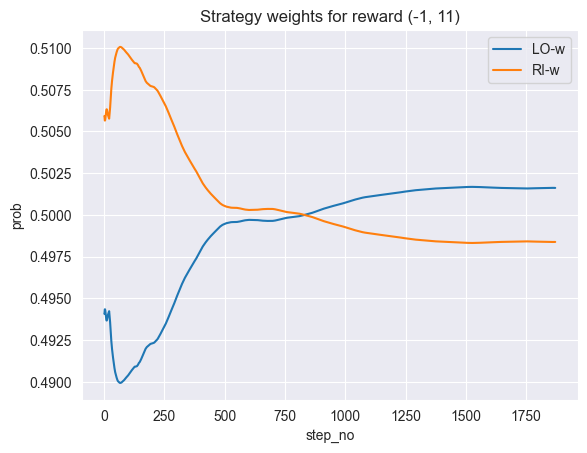

In [8]:
experiment(reward_values=(-1, 11))

# TEST 2
Reward distributions (test_2): 1:1, 1:4, 1:16, 1:32, 1:64, 1:128

Steps eg orig: [5, 10, 15, 2, 5, 3, 14, 7, 2, 47, 3, 99, 14, 9, 8, 2, 3, 6, 21, 3, 13, 14, 12, 1, 12, 20, 7, 7, 2, 3, 4, 20, 4, 16, 4, 25, 7, 5, 5, 9, 11, 5, 5, 3, 8, 7, 6, 1, 46, 4, 12, 9, 8, 9, 9, 11, 6, 12, 1, 4, 10, 16, 9, 5, 12, 12, 12, 1, 1, 1, 34, 5, 5, 2, 6, 4, 13, 28, 2, 5, 6, 5, 12, 28, 4, 16, 3, 9, 7, 16, 15, 11, 4, 5, 7, 7, 13, 8, 8, 2, 12, 17, 3, 10, 22, 2, 4, 3, 10, 11, 6, 23, 16, 4, 1, 1, 13, 6, 18, 7, 4, 4, 15, 5, 5, 3, 5, 10, 30, 17, 27, 16, 8, 5, 4, 8, 8, 4, 7, 9, 3, 34, 13, 8, 32, 6, 4, 14, 3, 11, 17, 24, 5, 8, 7, 2, 84, 3, 14, 6, 9, 5, 15, 5, 10, 24, 11, 21, 10, 4, 1, 29, 17, 7, 4, 4, 3, 9, 18, 2, 19, 4, 14, 3, 5, 5, 10, 6, 4, 6, 8, 12, 8, 8, 14, 2, 14, 5, 1, 10]


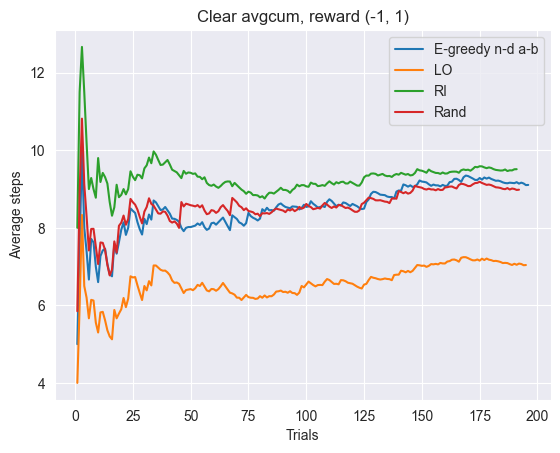

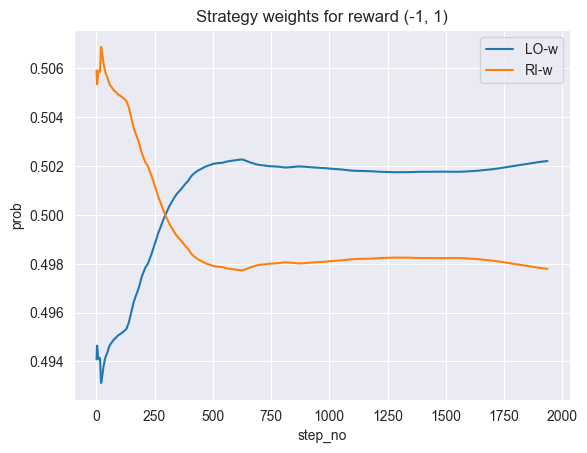

In [9]:
experiment(reward_values=(-1, 1))

Steps eg orig: [5, 10, 15, 2, 5, 3, 14, 7, 2, 49, 3, 99, 12, 9, 8, 2, 3, 11, 21, 3, 10, 11, 12, 1, 12, 20, 6, 7, 1, 1, 1, 21, 7, 16, 3, 27, 7, 5, 5, 10, 11, 5, 4, 1, 8, 8, 5, 2, 37, 1, 16, 9, 8, 8, 9, 9, 6, 12, 1, 2, 8, 14, 11, 7, 12, 12, 12, 4, 1, 1, 20, 5, 5, 2, 6, 3, 13, 19, 2, 5, 8, 5, 12, 20, 4, 14, 6, 9, 6, 14, 15, 14, 4, 6, 7, 6, 15, 3, 12, 3, 12, 24, 6, 12, 19, 5, 2, 3, 10, 11, 7, 17, 16, 4, 1, 1, 8, 5, 19, 10, 4, 2, 12, 5, 6, 3, 5, 8, 27, 16, 30, 17, 6, 6, 4, 10, 9, 4, 5, 9, 3, 37, 13, 8, 34, 6, 6, 12, 2, 12, 18, 30, 5, 7, 6, 2, 69, 11, 10, 6, 9, 6, 15, 5, 8, 21, 11, 16, 9, 5, 1, 20, 15, 7, 4, 3, 3, 7, 19, 3, 16, 1, 14, 3, 5, 5, 11, 7, 4, 4, 8, 16, 6, 6, 13, 2, 16, 9, 1, 8]


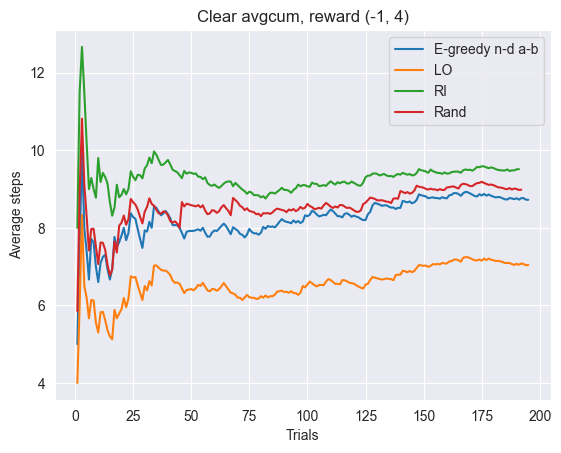

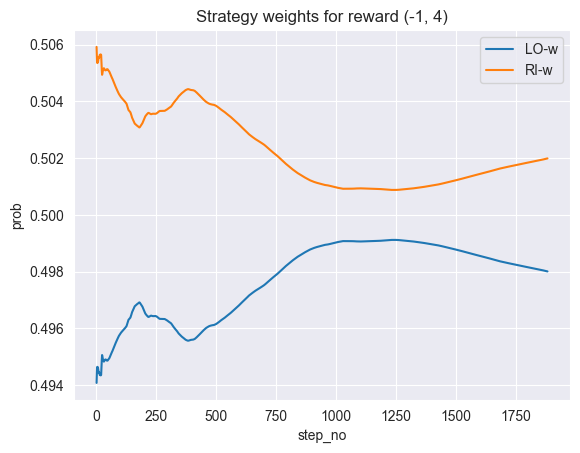

In [10]:
experiment(reward_values=(-1, 4))

Steps eg orig: [5, 10, 15, 2, 5, 3, 14, 7, 2, 46, 3, 99, 14, 9, 8, 2, 3, 6, 22, 3, 22, 14, 12, 2, 12, 20, 6, 7, 2, 2, 1, 17, 8, 17, 5, 26, 7, 5, 5, 9, 11, 8, 4, 3, 6, 11, 6, 1, 42, 1, 12, 9, 8, 6, 5, 11, 5, 12, 1, 2, 10, 15, 10, 7, 12, 13, 12, 1, 3, 1, 34, 5, 4, 2, 6, 4, 13, 19, 3, 8, 6, 5, 12, 18, 4, 14, 3, 9, 7, 15, 15, 13, 4, 4, 7, 6, 13, 3, 9, 2, 12, 11, 3, 10, 22, 4, 2, 3, 10, 12, 7, 23, 16, 4, 1, 5, 11, 6, 18, 13, 4, 4, 15, 5, 2, 3, 6, 4, 27, 14, 15, 16, 10, 8, 4, 8, 9, 4, 7, 9, 3, 36, 9, 7, 31, 5, 6, 12, 2, 12, 17, 24, 5, 8, 8, 5, 99, 3, 14, 6, 9, 6, 15, 5, 8, 18, 11, 17, 10, 5, 1, 20, 12, 7, 4, 2, 4, 7, 18, 4, 16, 1, 14, 4, 5, 4, 10, 8, 4, 3, 8, 6, 2, 10, 15, 2, 14, 9, 1, 11]


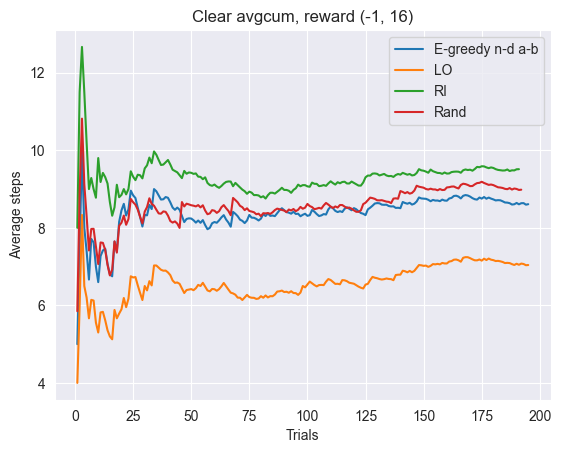

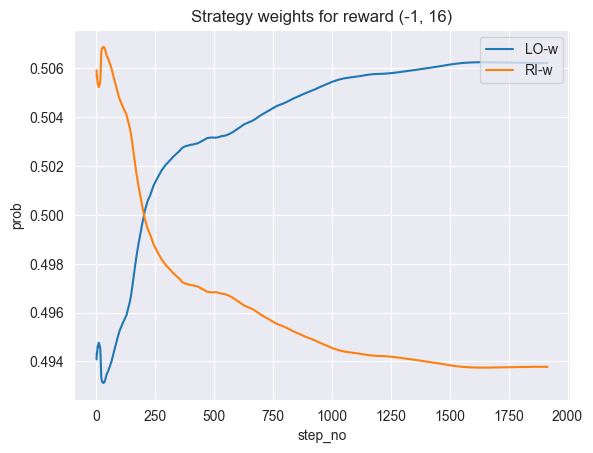

In [11]:
experiment(reward_values=(-1, 16))

Steps eg orig: [5, 10, 15, 2, 5, 3, 14, 7, 2, 51, 3, 99, 12, 6, 4, 2, 3, 7, 20, 2, 20, 12, 12, 6, 12, 20, 6, 7, 1, 1, 1, 22, 12, 16, 4, 30, 7, 5, 5, 11, 7, 12, 5, 1, 4, 10, 6, 1, 42, 1, 11, 9, 8, 5, 9, 9, 6, 12, 1, 1, 8, 13, 10, 8, 11, 17, 12, 2, 1, 1, 34, 5, 4, 2, 6, 4, 13, 15, 4, 9, 6, 5, 12, 22, 4, 14, 2, 9, 7, 13, 15, 10, 4, 3, 7, 4, 15, 3, 7, 2, 12, 9, 3, 10, 22, 6, 4, 3, 10, 11, 7, 20, 16, 4, 1, 2, 10, 6, 18, 11, 4, 4, 11, 5, 5, 4, 5, 4, 28, 11, 22, 16, 9, 5, 4, 8, 9, 9, 7, 8, 3, 36, 12, 8, 37, 6, 3, 12, 2, 11, 18, 27, 8, 6, 8, 2, 84, 3, 14, 6, 9, 6, 15, 5, 10, 15, 12, 14, 9, 5, 1, 23, 10, 9, 3, 2, 3, 7, 15, 2, 16, 1, 14, 3, 5, 6, 10, 8, 4, 6, 8, 11, 2, 6, 14, 2, 13, 9, 6, 9]


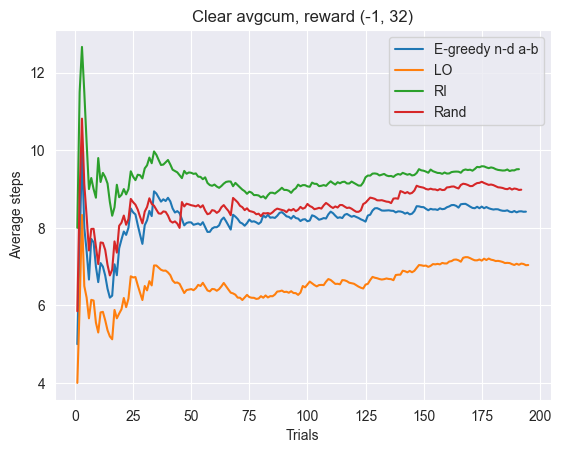

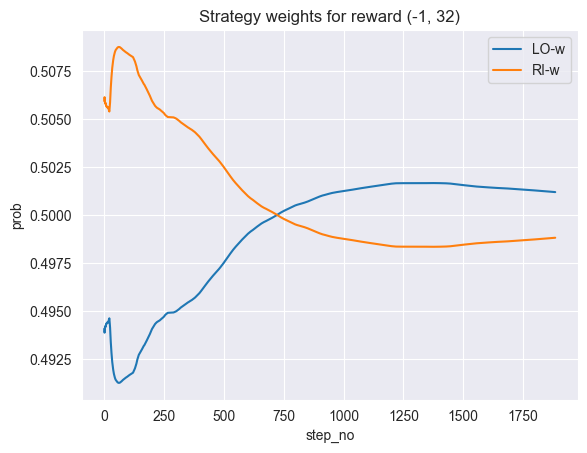

In [12]:
experiment(reward_values=(-1, 32))

Steps eg orig: [5, 10, 15, 2, 5, 3, 14, 7, 2, 56, 3, 99, 12, 8, 7, 2, 3, 6, 23, 3, 16, 13, 12, 1, 12, 20, 7, 7, 1, 3, 2, 20, 5, 16, 4, 24, 7, 5, 5, 11, 9, 7, 4, 1, 5, 8, 6, 3, 42, 2, 13, 9, 8, 6, 9, 12, 6, 12, 1, 2, 9, 11, 9, 5, 12, 14, 12, 1, 2, 1, 34, 5, 5, 1, 6, 2, 12, 20, 2, 8, 6, 4, 12, 20, 4, 16, 2, 9, 7, 13, 15, 10, 4, 5, 7, 6, 15, 2, 10, 4, 12, 23, 6, 14, 16, 2, 6, 3, 10, 11, 7, 23, 17, 4, 1, 3, 13, 6, 19, 9, 4, 2, 9, 5, 6, 2, 9, 4, 27, 10, 21, 18, 7, 5, 4, 6, 7, 4, 7, 9, 3, 38, 11, 8, 35, 6, 3, 12, 4, 11, 17, 31, 5, 8, 6, 2, 99, 3, 14, 6, 9, 6, 15, 5, 10, 17, 12, 15, 10, 5, 1, 27, 10, 7, 4, 2, 4, 7, 16, 2, 16, 1, 14, 4, 5, 6, 11, 7, 4, 2, 8, 19, 4, 7, 16, 2, 15, 8, 2, 8]


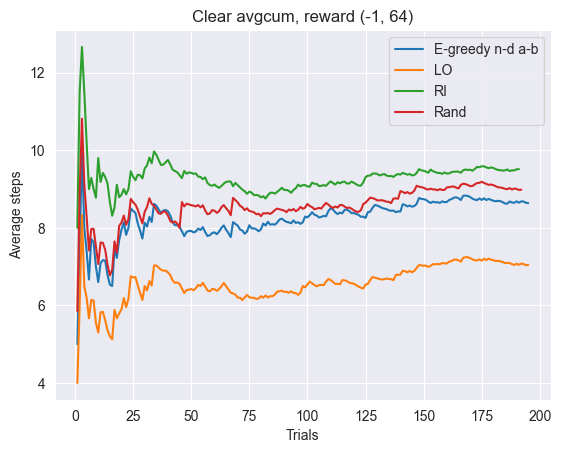

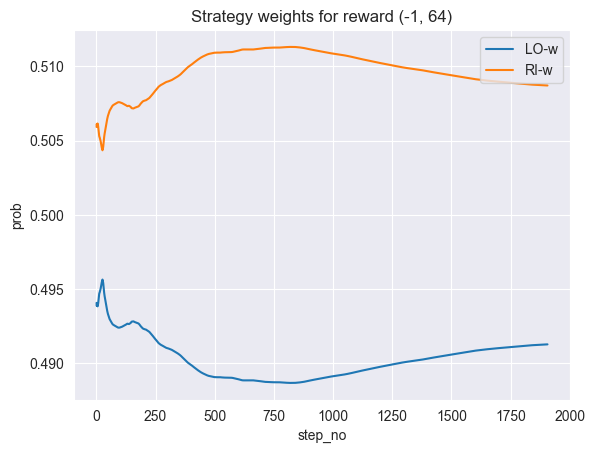

In [13]:
experiment(reward_values=(-1, 64))

Steps eg orig: [5, 10, 15, 2, 5, 3, 14, 7, 2, 46, 3, 99, 12, 8, 4, 2, 3, 7, 20, 2, 15, 14, 12, 2, 12, 20, 6, 7, 1, 1, 4, 19, 10, 16, 3, 27, 7, 5, 5, 10, 12, 12, 4, 1, 5, 12, 6, 2, 42, 2, 12, 9, 8, 7, 9, 12, 6, 12, 1, 1, 6, 11, 11, 7, 12, 12, 12, 1, 1, 1, 34, 5, 5, 2, 6, 4, 13, 16, 2, 8, 7, 5, 12, 29, 4, 16, 3, 9, 7, 15, 15, 10, 4, 6, 7, 4, 15, 5, 11, 5, 12, 9, 6, 14, 18, 6, 9, 3, 10, 11, 6, 21, 16, 4, 1, 2, 16, 6, 18, 9, 4, 4, 8, 5, 4, 5, 4, 5, 31, 10, 21, 16, 8, 5, 4, 6, 9, 9, 7, 9, 4, 38, 13, 8, 30, 5, 3, 14, 3, 12, 17, 24, 5, 8, 8, 2, 84, 11, 12, 6, 9, 6, 15, 5, 11, 15, 11, 17, 15, 5, 1, 30, 12, 7, 13, 5, 3, 7, 19, 2, 10, 2, 14, 2, 5, 4, 10, 7, 4, 5, 8, 14, 2, 4, 15, 2, 19, 9, 1, 11]


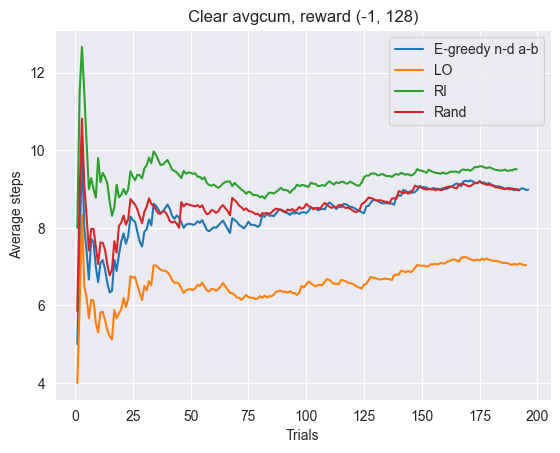

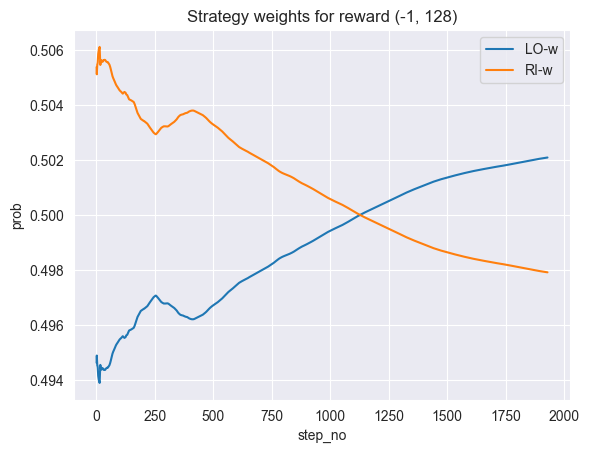

In [14]:
experiment(reward_values=(-1, 128))

In [15]:
reward_values_all = ((-1, 0), (-1, 1), (-1, 2), (-1, 4), (-1, 8), (-1, 9), (-1, 10),
                      (-1, 11), (-1, 12), (-1, 16), (-1, 32), (-1, 64), (-1,100), (-1, 128))

In [16]:
def experiment_v2(reward_values=(-1, 0)):
    env = LambdaEnv(strategies=strategies_env,
                    lambda_terms=terms,
                    max_step_term=max_count_steps_rlenv,
                    count_terms=len(terms),
                    reward_values=(-1, 0))

    _, steps_env = \
        run_e_greedy_policy(environment=env,
                            exploration=explore_actions,
                            max_term_reward=max_count_steps_rlenv,
                            epsilon=epsilon,
                            deterministic=False,
                            is_action_based=True,
                            return_steps=True)
    wh_env = np.array(env.get_weights_history())

    return steps_env, wh_env

def get_expected_steps(data):
    steps = [x for x in data if x != float("inf")]
    steps = [x for x in steps if x != 0]

    distributions = get_common_distributions()
    distributions.remove("expon")
    distributions.remove("cauchy")
    f = Fitter(steps, distributions=distributions)
    f.fit()

    f_ln = Fitter([np.log(step) for step in steps], distributions=distributions)
    f_ln.fit()
    mu, sigma = f_ln.fitted_param["norm"]
    expected_value = np.e ** (mu + (sigma ** 2) / 2)

    return expected_value, mu, sigma


def draw_wh(wh_env, reward_values):
    comp_data = {
        "LO-w": (wh_env[:, 0], "-"),
        "RI-w": (wh_env[:, 1], "-")
    }
    draw_mult_lines(comp_data, title=f"Strategy weights for reward {reward_values}",
                    x_label="step_no", y_label="prob")

In [17]:
steps_env_all, wh_all = [], []

for rew_values in tqdm(reward_values_all):
    steps_, wh_ = experiment_v2(rew_values)
    steps_env_all.append(steps_)
    wh_all.append(wh_)

100%|██████████| 14/14 [00:22<00:00,  1.63s/it]


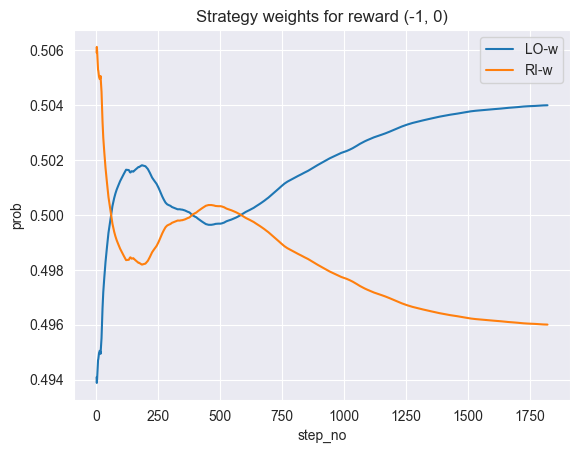

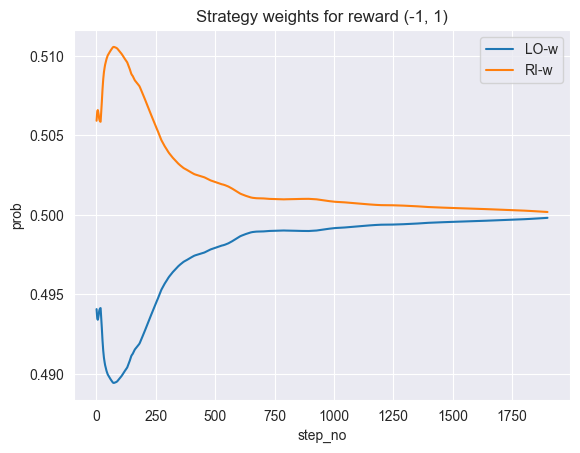

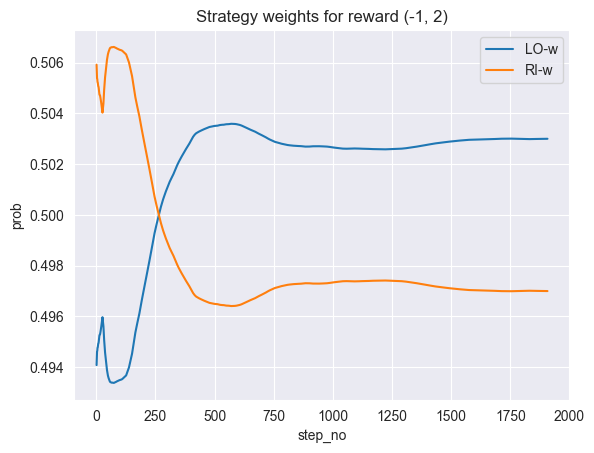

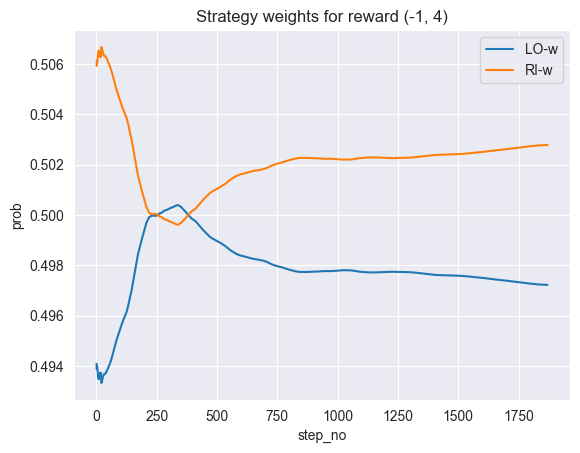

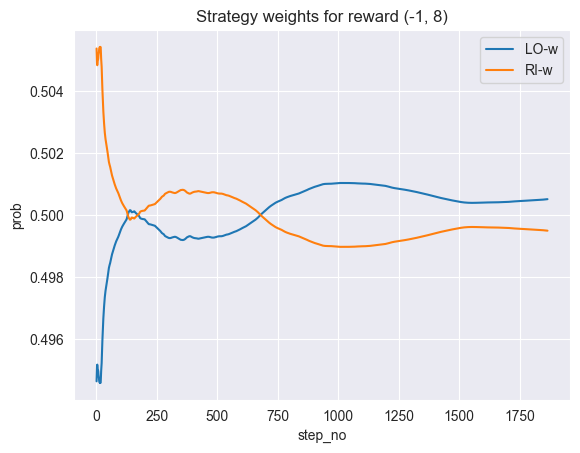

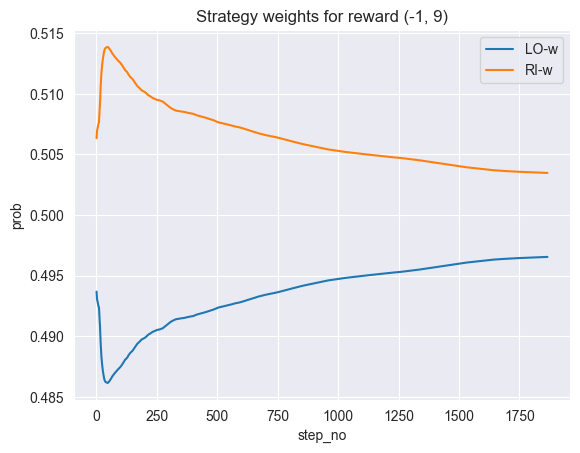

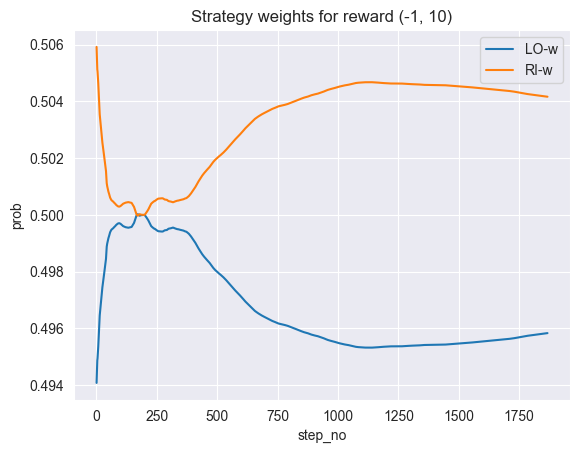

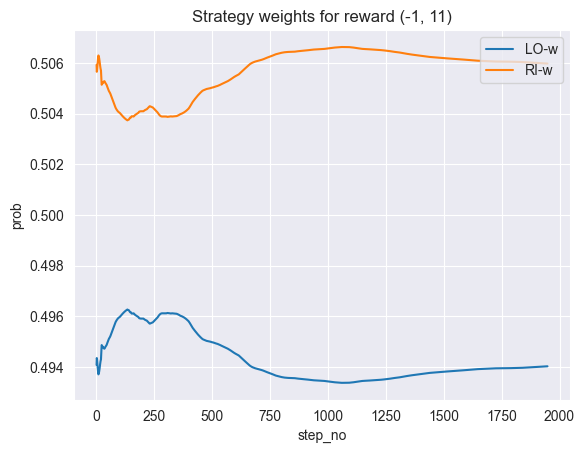

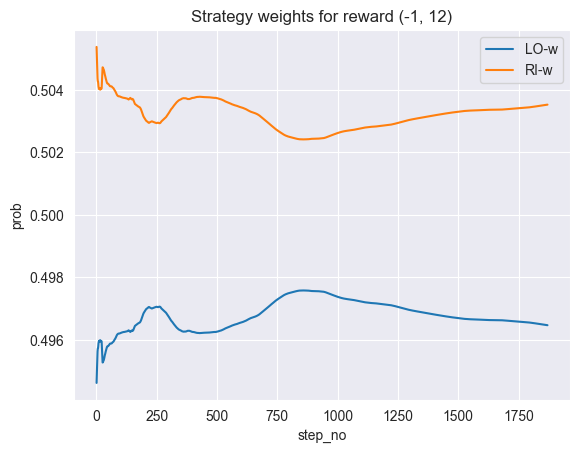

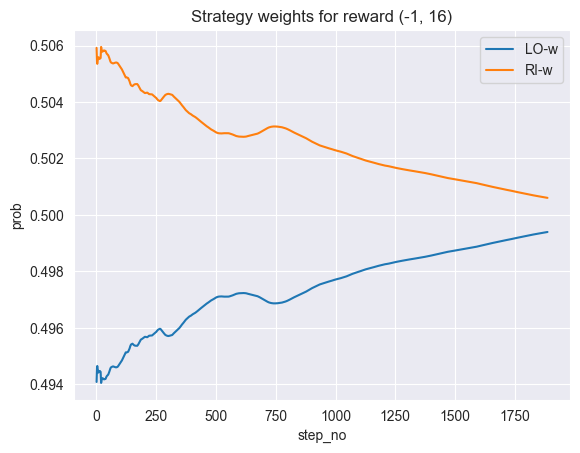

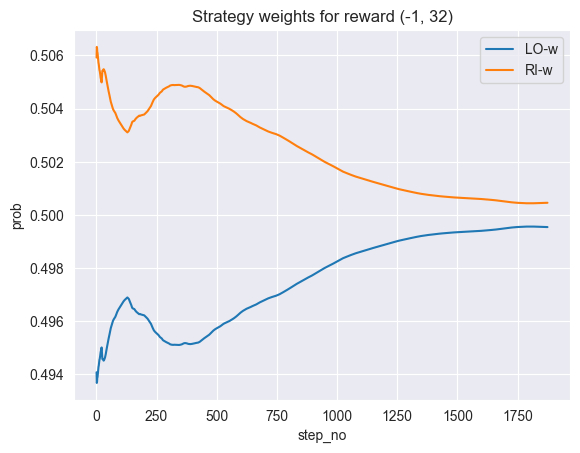

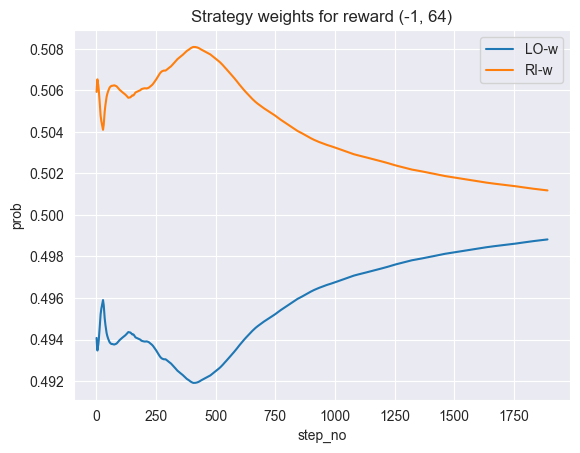

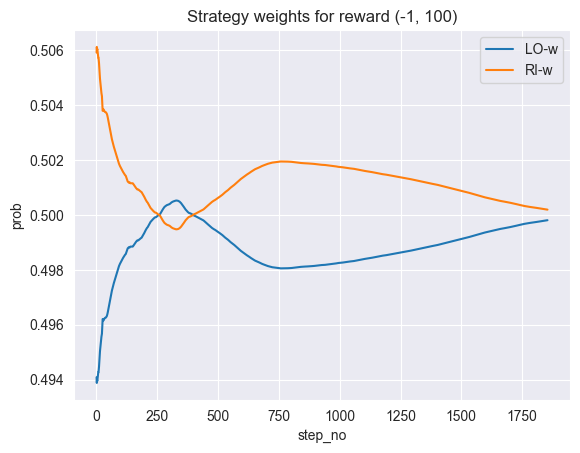

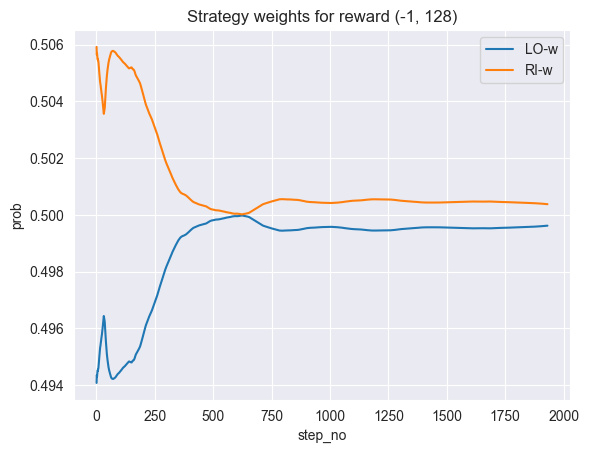

In [18]:
for inx, rew_values in enumerate(reward_values_all):
    draw_wh(wh_env=wh_all[inx], reward_values=rew_values)

In [19]:
expected_value_LO, mu_LO, sigma_LO = get_expected_steps(stepsLO)
expected_value_RI, mu_RI, sigma_RI = get_expected_steps(stepsRI)
expected_value_rand, mu_rand, sigma_rand = get_expected_steps(stepsRand)

Fitting 8 distributions: 100%|██████████| 8/8 [00:00<00:00, 24.38it/s]


In [20]:
expected_value_all, mu_all, sigma_all = [], [], []
for steps_ in steps_env_all:
    expected_value_, mu_, sigma_ = get_expected_steps(clear_arr(steps_))
    expected_value_all.append(expected_value_)
    mu_all.append(mu_)
    sigma_all.append(sigma_)

Fitting 8 distributions: 100%|██████████| 8/8 [00:00<00:00, 22.09it/s]


In [21]:
print(f"LO Log Norm: mu={mu_LO}, sigma={sigma_LO}; expected value={expected_value_LO}")
print(f"RI Log Norm: mu={mu_RI}, sigma={sigma_RI}; expected value={expected_value_RI}")
print(f"Rand Log Norm: mu={mu_rand}, sigma={sigma_rand}; expected value={expected_value_rand}")

LO Log Norm: mu=1.7082325984365598, sigma=0.9256831664202053; expected value=8.471243081238516
RI Log Norm: mu=2.124384710471896, sigma=0.5670607368861972; expected value=9.827294330433483
Rand Log Norm: mu=2.016166757804208, sigma=0.668480355666543; expected value=9.389572366039083


In [22]:
for inx, rew_values in enumerate(reward_values_all):
    print(f"{rew_values} Log Norm: mu={mu_all[inx]}, sigma={sigma_all[inx]}; expected value={expected_value_all[inx]}")

(-1, 0) Log Norm: mu=1.8373579515226026, sigma=0.8066364247883453; expected value=8.694486702470394
(-1, 1) Log Norm: mu=1.8884807485028572, sigma=0.8322528979978263; expected value=9.344642567204144
(-1, 2) Log Norm: mu=1.8502704203835347, sigma=0.8348303033121154; expected value=9.013660302806498
(-1, 4) Log Norm: mu=1.879710696074263, sigma=0.7777452323218742; expected value=8.865386342882504
(-1, 8) Log Norm: mu=1.8731925066030521, sigma=0.7826909073662908; expected value=8.84184030993458
(-1, 9) Log Norm: mu=1.8822743684218195, sigma=0.8204769740777927; expected value=9.196892000237225
(-1, 10) Log Norm: mu=1.867727711145044, sigma=0.78910946468132; expected value=8.83812353896932
(-1, 11) Log Norm: mu=1.8786178192159366, sigma=0.844987207558925; expected value=9.352273882149305
(-1, 12) Log Norm: mu=1.8891320045627606, sigma=0.7925177636225758; expected value=9.053706278315747
(-1, 16) Log Norm: mu=1.892831847499295, sigma=0.7726288313341246; expected value=8.946921467499271
(-1,

In [23]:
inx = expected_value_all.index(min(expected_value_all))
print(f"{reward_values_all[inx]} Log Norm: mu={mu_all[inx]}, sigma={sigma_all[inx]}; expected value={expected_value_all[inx]}")

(-1, 0) Log Norm: mu=1.8373579515226026, sigma=0.8066364247883453; expected value=8.694486702470394
